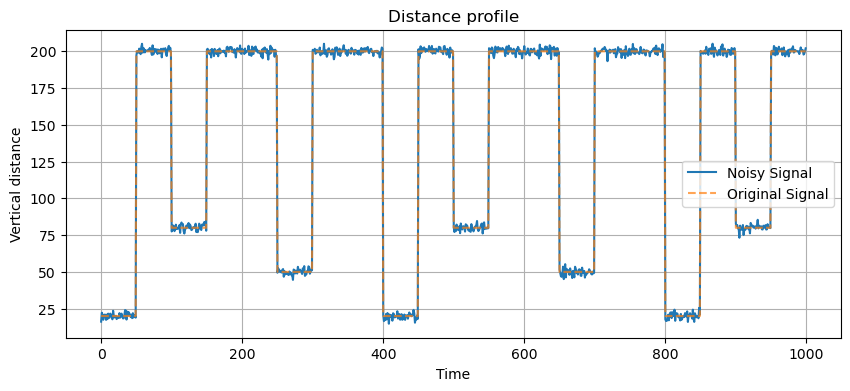

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.precision", 3)

# Parameters
samples = 1000       # Total number of samples
noise_std = 2        # Standard deviation of the noise
dist_to_top = 200    # Distance to top of tree (cm)
branch_positions = [0, 100, 250, 400, 500, 650, 800, 900]  # Positions where the branches occur
branch_heights = [20, 80, 50, 20, 80, 50, 20, 80]          # Heights of the branches (cm)
branch_width = 50    # Width of the branch in time units when horizontally travelling the tree

# Generate the ultrasonic distance signal
signal = np.full(samples, dist_to_top)

for pos, height in zip(branch_positions, branch_heights):
    signal[pos:pos+branch_width] = height

# Add normally distributed noise
noise = np.random.normal(0, noise_std, samples)
noisy_signal = signal + noise

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(noisy_signal, label='Noisy Signal')
plt.plot(signal, linestyle='--', label='Original Signal', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Vertical distance')
plt.title('Distance profile')
plt.legend()
plt.grid(True)
plt.savefig('distance_profile.png')
plt.show()

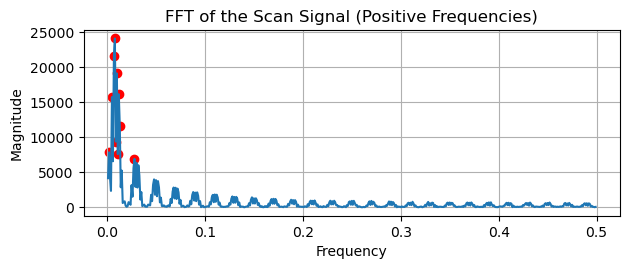

   Frequency   Period  Magnitude
0      0.008  125.000  24144.069
1      0.007  142.857  21674.186
2      0.010  100.000  19146.197
3      0.012   83.333  16161.719
4      0.005  200.000  15754.886
5      0.013   76.923  11680.579
6      0.009  111.111   9399.532
7      0.002  500.000   7863.382
8      0.011   90.909   7612.667
9      0.028   35.714   6935.879
Estimated Period: 125.00


In [2]:
n_dom_freqs = 10  # Number of dominant frequencies to find

# Perform FFT
fft_result = np.fft.fft(noisy_signal)
frequencies = np.fft.fftfreq(samples)

# Get the magnitude of the FFT result
fft_magnitude = np.abs(fft_result)

# Consider only the positive frequencies (don't care about negative since magnitude is symmetric).
# This also means ignoring the zero frequency there is a huge bias towards it
# since the signal is not centered around zero and is mostly flat at the top.
pos_freq_idxs = frequencies > 0
frequencies = frequencies[pos_freq_idxs]
magnitudes = fft_magnitude[pos_freq_idxs]

# Find the indices of the n most dominant positive frequencies
dom_idxs = np.argsort(magnitudes)[-n_dom_freqs:]
dom_freqs = frequencies[dom_idxs]
dom_mags = magnitudes[dom_idxs]

# Plot the FFT magnitude for positive frequencies
plt.subplot(2, 1, 2)
plt.plot(frequencies, magnitudes)
plt.scatter(dom_freqs, dom_mags, color='red')
# plt.axvline(dom_freqs[-1], color='green', linestyle='--')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of the Scan Signal (Positive Frequencies)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the dominant positive frequencies and their magnitudes
# for freq, mag in zip(dom_freqs, dom_mags):
#     print(f"Frequency: {freq:.4f}, Magnitude: {mag:.3f}")

# Use pandas to print the frequencies and magnitudes in a table
dom_freqs = np.flip(dom_freqs, axis=0)
dom_mags = np.flip(dom_mags, axis=0)
dom_periods = 1 / dom_freqs
df = pd.DataFrame({'Frequency': dom_freqs, 'Period': dom_periods, 'Magnitude': dom_mags})
# df.style \
#   .format(precision=3, thousands=",", decimal=".")
print(df)

# Estimated period is the reciprocal of the dominant frequency
estimated_period = 1 / dom_freqs[0]
print(f"Estimated Period: {estimated_period:.2f}")

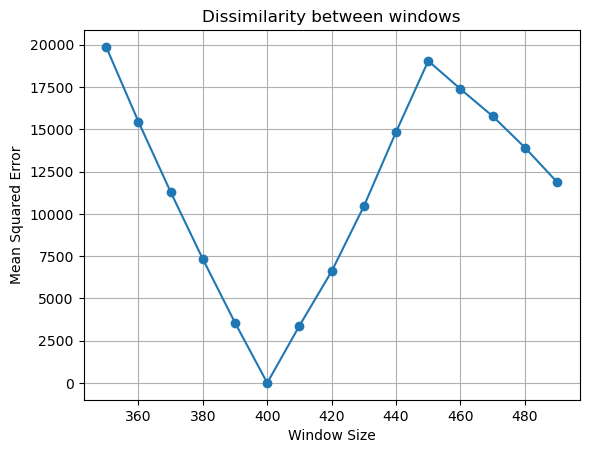

Estimated Period: 400


In [4]:
window_min  = 350  # Hypothesized period length
window_max  = 500  # falls between window
window_incr = 10   

def compute_dissimilarity(window1, window2):
    # Compute mse. Lower value means more similar
    return np.mean((window1 - window2) ** 2)

# Compare windows to detect repetition
dissimilarities = [] # Store the dissimilarity values
first_window = noisy_signal[:window_min] 

for win_size in range(window_min, window_max, window_incr):
    if 2*win_size > samples:
        break
    first_window = noisy_signal[:win_size]
    current_window = noisy_signal[win_size:2*win_size]
    dissimilarity = compute_dissimilarity(first_window, current_window)  # Compute dissimilarity (mse: a scalar value)
    dissimilarities.append(dissimilarity)

# Plot the dissimilarities
x_values = range(window_min, window_max, window_incr)#[:-1]
plt.plot(x_values, dissimilarities, marker='o')
plt.title('Dissimilarity between windows')
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

# Identify the greatest window dissimilarity (smallest mse)
min_dissimilarity_idx = np.argmin(dissimilarities)
estimated_period = x_values[min_dissimilarity_idx]
print(f'Estimated Period: {estimated_period}')